# Neural style transfer

In neural style transfer, we have a content image and a style image, and we combine
these two images in such a way that the combined image preserves the content of the
content image while maintaining the style of the style image.

![imgs](./imgs/m4.png)

1. Pass the input image through a pre-trained model.

2. Extract the layer values at pre-defined layers.

3. Pass the generated image through the model and extract its values at the
same pre-defined layers.

4. Calculate the content loss at each layer corresponding to the content image
and generated image.

5. Pass the style image through multiple layers of the model and calculate the
gram matrix values of the style image.

6. Pass the generated image through the same layers that the style image is
passed through and calculate its corresponding gram matrix values.

7. Extract the squared difference of the gram matrix values of the two images.
This will be the style loss.

8. The overall loss will be the weighted average of the style loss and content
loss.

9. The input image that minimizes the overall loss will be the final image of
interest.

In the preceding picture, we want to retain the content in the picture on right (the
content image), but overlay it with the color and texture in the picture on the left (the
style image).

The process of performing neural style transfer is as follows. We try to modify the
original image in a way that the loss value is split into <b> content loss </b> and <b> style loss </b>.
Content loss refers to how <b> different </b> the generated image is from the content image.
Style loss refers to how <b> correlated </b> the style image is to the generated image.

While we mentioned that the loss is calculated based on the difference in images, in
practice, we modify it slightly by ensuring that the loss is calculated using the feature
layer activations of images and not the original images. For example, the content loss
at layer 2 will be the squared difference between the <i> activations of the content image </i> and the generated image when passed through the second layer.

Loss is calculated on feature layers and not the original image, as the feature layers
capture certain attributes of the original image (for example, the outline of the
foreground corresponding to the original image in the higher layers and the details of
fine-grained objects in the lower layers).

While calculating the content loss seems straightforward, let's try to understand how
to calculate the similarity between the generated image and the style image. A
technique called <b> gram matrix </b> comes in handy. Gram matrix calculates the similarity
between a generated image and a style image, and is calculated as follows:

![imgs](./imgs/m5.png)

<i> GM[l] </i> is the gram matrix value at layer l for the style image, S, and the generated
image, G.

A gram matrix results from multiplying a matrix by the transpose of itself. Let's
understand the use of this operation.

Imagine that you are working on a layer that has a feature output of 32 x 32 x 256. The
gram matrix is calculated as the correlation of each of the 32 x 32 values in a channel
with respect to the values across all channels. Thus, the gram matrix calculation
results in a matrix that is 256 x 256 in shape. We now compare the 256 x 256 values of
the style image and the generated image to calculate the style loss.

Let's understand why GramMatrix is important for style transfer.

In a successful scenario, say we transferred Picasso's style to the Mona Lisa. Let's call
the Picasso style St (for style), the original Mona Lisa So (for source), and the final
image Ta (for target). Note that in an ideal scenario, the local features in image Ta are
the same as the local features in St. Even though the content might not be the same,
getting similar colors, shapes, and textures as the style image into the target image is
what is important in style transfer.

By extension, if we were to send So and extract its features from an intermediate layer
of VGG19, they will vary from the features obtained by sending Ta. However, within
each feature set, the corresponding vectors will vary relatively with each other in a
similar fashion. Say, for example, the ratio of the mean of the first channel to the mean
of the second channel in both the feature sets will be similar. This is why we are
trying to compute using Gram Loss.

Content loss is calculated by comparing the difference in feature
activations of the content image with respect to the generated image.
Style loss is calculated by first calculating the gram matrix in the
pre-defined layers and then comparing the gram matrices of the
generated image and the style image.

Now that we are able to calculate the style loss and the content loss, the final
modified input image is the image that minimizes the overall loss, that is, a weighted
average of the style and content loss.


In [1]:
%pip install torch_snippets
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Note: you may need to restart the kernel to use updated packages.


/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.models import vgg19
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [3]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval() 
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


In [4]:
vgg = vgg19_modified().to(device)

/home/lacie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/lacie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
!wget https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
!wget https://www.dropbox.com/s/1svdliljyo0a98v/style_image.png

--2023-08-15 14:03:38--  https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/z1y0fy2r6z6m6py/60.jpg [following]
--2023-08-15 14:03:38--  https://www.dropbox.com/s/raw/z1y0fy2r6z6m6py/60.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb124b58ba32c17e9a015f6a33a.dl.dropboxusercontent.com/cd/0/inline/CB1ClO-4sM1Z93cLCpPRTpP9RbBaHeV_tX778fEARvzzthPqKCoAEjca5cxq9Oo1ObqDTB1SoSLLQSuZ_1msxZ6wlhU7QMOippKOt-kgFI9l_5SNHKyH5ty9tLLYqkTCDew/file# [following]
--2023-08-15 14:03:39--  https://ucb124b58ba32c17e9a015f6a33a.dl.dropboxusercontent.com/cd/0/inline/CB1ClO-4sM1Z93cLCpPRTpP9RbBaHeV_tX778fEARvzzthPqKCoAEjca5cxq9Oo1ObqDTB1SoSLLQSuZ_1msxZ6wlhU7QMOippKOt-kgFI9l_5SNHKyH5ty9tLLYqkTCDew/file
R

In [7]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.png', '60.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [8]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [9]:
style_layers = [0, 5, 10, 19, 28] 
content_layers = [21]
loss_layers = style_layers + content_layers

In [10]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [11]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]] 
content_weights = [1]
weights = style_weights + content_weights

In [12]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [13]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [14]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000  loss: 9734914.000  (51.51s - -0.21s remaining))))ng)

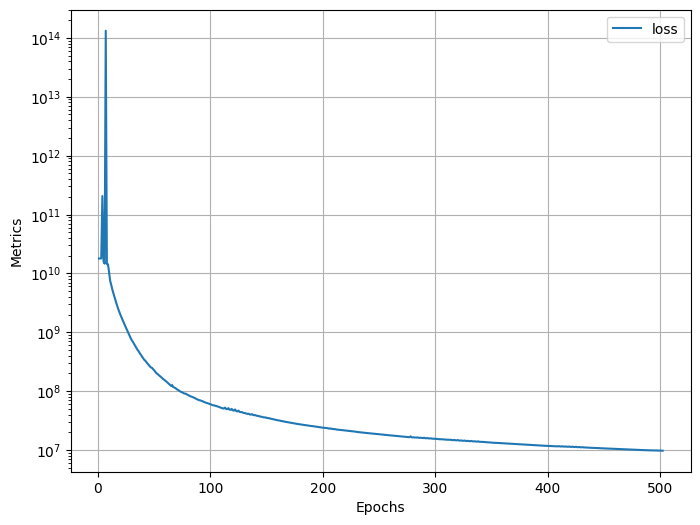

In [15]:
log.plot(log=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


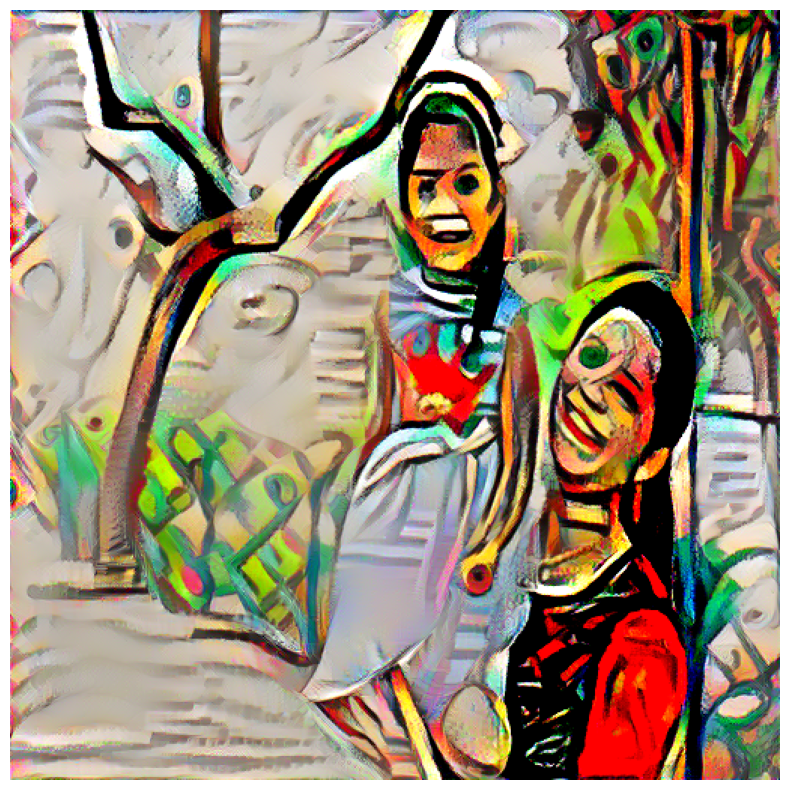

In [16]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)